# Language Recognition

Two day hackathon

Predicting which South African language is being used in a tweet.

In [1]:
# Other
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# Data processing
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from scipy import sparse
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from langdetect import detect, detect_langs
from imblearn.under_sampling import RandomUnderSampler 


# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score


# Models
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Classification report
from sklearn.metrics import classification_report ,log_loss

In [2]:
#Loading data
test_set = 'test_set.csv'
train_set = 'train_set.csv'
train = pd.read_csv(train_set)
test = pd.read_csv(test_set)

In [3]:
#Spliting up index column for exporting
index = test['index']
test = test.drop('index',axis=1)

In [4]:
# quick look at how many columns our dataset is made of
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [5]:
train

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...


In [6]:
#removing duplicates
train.drop_duplicates(subset = "text", keep = False, inplace = True) 

In [7]:
train.shape

(27401, 2)

Alrighty so its only one feature and one label. Well at this point in time. Let's take a deeper look.

In [8]:
# Creating a single string containing all tweets
def corpus(df,column):
    return_string = ''
    """Loooooooooping through each row of specified column
       adding the string to return_string
       return whole column as one string
    """
    for i in range(len(df[column])):
        return_string = return_string + ' ' + df[column].iloc[i]
    
    return return_string

In [9]:
%%time

tweets = corpus(train,'text')

Wall time: 55.1 s


Creating a word cloud to show most common words.

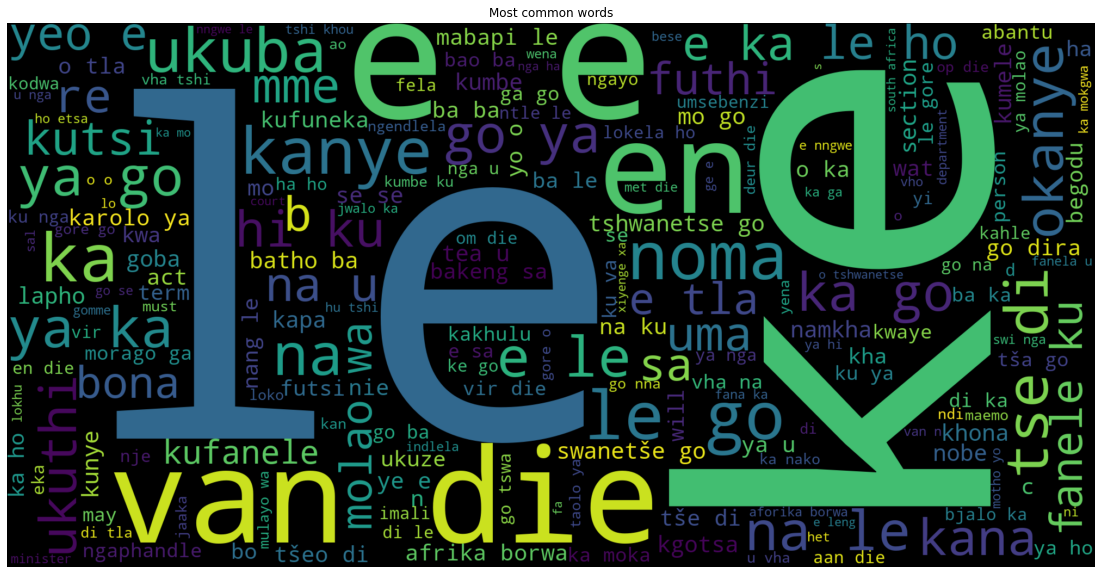

In [10]:
# initializing word cloud
word_cloud = WordCloud(width=2000, height=1000, background_color="black").generate(tweets)

plt.figure(figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("Most common words")
plt.axis('off')
# Display the figure
plt.show()

Well seeing as I do not understand most of that, I can't say if most of those words hold any value. So for now we can move on.

Lets take a look at our lables.

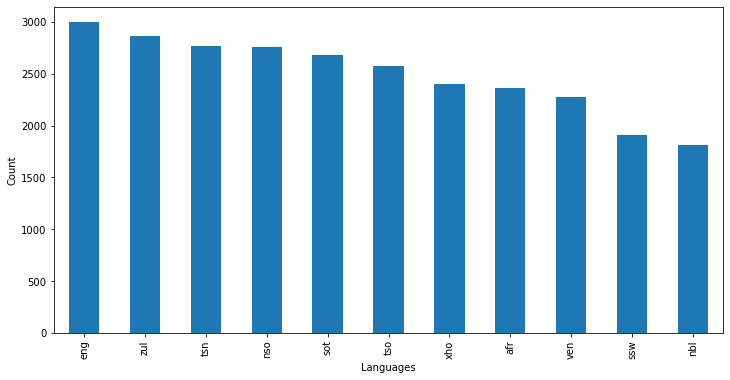

In [11]:
# ploting the amount of times each label appears

train['lang_id'].value_counts().plot(kind = 'bar',figsize=(12,6))
plt.ylabel('Count')
plt.xlabel('Languages')
plt.show()

Ok so there appears to be the imbalance in our labels. Will handle this later on.

Now lets see if we can get any information from our features.

In [12]:
# number of words/elements in post
def word_elements(post):
    return len(post.split(" "))

# word density
def word_den(post):
    den = len(post.split(" ")) / len(post)
    return den

In [13]:
%%time

# number of characters in string
train['char_count'] = train['text'].apply(len)
test['char_count'] = test['text'].apply(len)
# number of words/elements in a post
train['word_count'] = train['text'].apply(word_elements)
test['word_count'] = test['text'].apply(word_elements)
# word density
train['word_den'] = train['text'].apply(word_den)
test['word_den'] = test['text'].apply(word_den)

Wall time: 144 ms


In [14]:
# Dataset with new features
train

,lang_id,text,char_count,word_count,word_den
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,252,31,0.123016
2,eng,the province of kwazulu-natal department of tr...,264,37,0.140152
3,nso,o netefatša gore o ba file dilo ka moka tše le...,217,40,0.184332
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239,43,0.179916
5,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...,214,41,0.191589
...,...,...,...,...,...
32994,eng,manuel marin s ill-fated debt sources but very...,239,43,0.179916
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...,272,49,0.180147
32997,eng,closing date for the submission of completed t...,222,37,0.166667
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...,228,26,0.114035


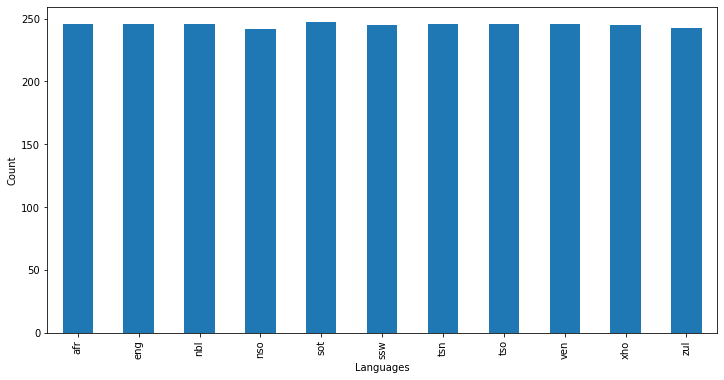

In [15]:
# group by labels, mean of each label
train.groupby('lang_id')["char_count"].mean().plot(kind = 'bar',figsize=(12,6))
plt.ylabel('Count')
plt.xlabel('Languages')
plt.show()

Each label evens out in character count so no value here.

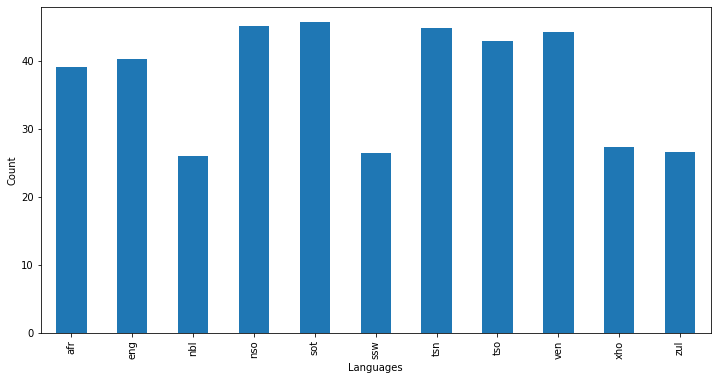

In [16]:
# group by labels, mean of each label
train.groupby('lang_id')["word_count"].mean().plot(kind = 'bar',figsize=(12,6))
plt.ylabel('Count')
plt.xlabel('Languages')
plt.show()

Alright here we can see that on average four of the languages use around 10 less words. Now this could be just complete random chance or the language just uses less words to "say" something.

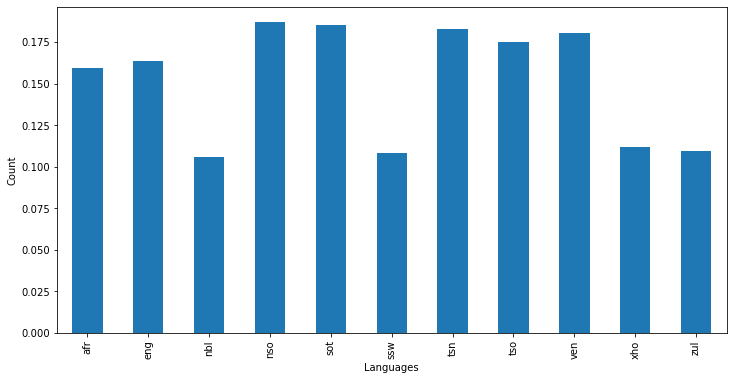

In [17]:
# group by labels, mean of each label
train.groupby('lang_id')["word_den"].mean().plot(kind = 'bar',figsize=(12,6))
plt.ylabel('Count')
plt.xlabel('Languages')
plt.show()

OK so the word density shows the same thing that the word count does. So I'll probably end up droping the word_count column for  word density because the values are closer to zero.

In [18]:
# count how many times each word  appears in the data set
words = Counter(word for word in tweets.split(" "))

In [19]:
com_words = words.most_common(500)
stopwords = []

# list of most occurring  words
for i in range(len(com_words)):
    stopwords.append(com_words[i][0])

In [20]:
len(words)

136095

Ok so we seem to have 136095 unique words/elements in the data set and I'm going to assume that the ones that appear the most are just common words that don't really mean anything on their own, think its called joining words or something. But if they are specific to a language then they could be important in determining the language at hand.

In [21]:
# check to see if words appear in more then one language

def commonwords(words):
    return_list = []
    lang_list = []
    count = 0
    
    for word in words:
#         print(word + " - " + str(count))
#         count+=1
        for i in range(len(train)):
            temp = train.iloc[i]["text"].split(" ")
            if word in temp:
                lang_list.append(train.iloc[i]["lang_id"])
                if len(set(lang_list)) > 2:
                    return_list.append(word)
                    lang_list.clear()
                    break
                
    return return_list

In [22]:
%%time
# creating a stopwords list
stopwords = commonwords(stopwords)

Wall time: 9min 24s


In [23]:
len(stopwords)

315

We will now use this list as our stop word list to remove words which are not distinct to a language.

### Encoding the labels for the model

In [24]:
# Fit label encoder and return encoded labels
le = LabelEncoder()
train['encoded'] = le.fit_transform(train['lang_id'])

In [25]:
encoded_label = train.drop_duplicates('lang_id').drop(['text'], axis=1).set_index('lang_id')

In [26]:
encode_dict = encoded_label["encoded"].to_dict()
encode_dict

{'xho': 9,
 'eng': 1,
 'nso': 3,
 'ven': 8,
 'tsn': 6,
 'ssw': 5,
 'zul': 10,
 'tso': 7,
 'sot': 4,
 'nbl': 2,
 'afr': 0}

Ok now we have a dictionary containing the labels and the value assigned to them.

### Splitting features and labels.

In [27]:
# X = features y = label
y = train['encoded']
X = train.drop(['lang_id','encoded'],axis=1)

In [28]:
# using RandomUnderSampler to get rid of the imbalance in the data set
undersample = RandomUnderSampler(sampling_strategy='auto',random_state=322)

In [29]:
X, y = undersample.fit_resample(X,y)

In [30]:
X.shape

(19910, 4)

In [31]:
# Adding more words to stopwords list
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

In [32]:
# create bag of words using sklrean CountVectorizer
countvec = CountVectorizer(max_features=None,ngram_range=(1,2),min_df=2,stop_words = stop_words, strip_accents='unicode')

# tfid = TfidfVectorizer(max_features=None,ngram_range=(1,1),min_df=1, stop_words = stop_words)

In [33]:
vec_X = countvec.fit_transform(X.text)

C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bosetshaba'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [34]:
vec_X.shape

(19910, 71030)

In [35]:
# Droping unused columns
X = X.drop(['text','char_count','word_count'],axis=1)

In [36]:
X = sparse.csr_matrix(X.values)

In [37]:
# Joining
X = hstack((vec_X, X))

In [38]:
X.shape

(19910, 71031)

Split data into training and testing sets

In [39]:
%%time
# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(vec_X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=12)

Wall time: 4.99 ms


## Models

In [40]:
%%time

rfc = RandomForestClassifier(random_state=322,n_estimators=20,max_depth=None)
rfc.fit(X_train, y_train)

Wall time: 6.29 s


RandomForestClassifier(n_estimators=20, random_state=322)

In [41]:
# train f1 score
pred = rfc.predict(X_train)
print('train - ', round(f1_score(y_train, pred,average='micro'),4))

# test
pred = rfc.predict(X_test)
print('test - ', round(f1_score(y_test, pred,average='micro'),4))

train -  0.9998
test -  0.9352


In [42]:
# test -  0.9730303

In [43]:
%%time

nb = MultinomialNB(alpha=0.2)
nb.fit(X_train, y_train)

Wall time: 25.9 ms


MultinomialNB(alpha=0.2)

In [44]:
# train f1 score
pred = nb.predict(X_train)
print('train - ', round(f1_score(y_train, pred,average='micro'),4))

# test
pred = nb.predict(X_test)
print('test - ', round(f1_score(y_test, pred,average='micro'),7))

train -  0.9999
test -  0.9969864


In [45]:
# test -  0.999697   == 0.96545

In [46]:
# cross validtaion
cross_val = cross_val_score(nb, X_train, y_train, cv=5)
print("Mean cross-validtaion accuracy: " + str(cross_val.mean()))

Mean cross-validtaion accuracy: 0.9965470203726863


In [47]:
%%time
clf = svm.SVC()
clf.fit(X_train,y_train)

Wall time: 43.7 s


SVC()

In [48]:
# train f1 score
pred = clf.predict(X_train)
print('train - ', round(f1_score(y_train, pred,average='micro'),4))

# test
pred = clf.predict(X_test)
print('test - ', round(f1_score(y_test, pred,average='micro'),7))

train -  0.9991
test -  0.9751381


### Prepping test data

In [49]:
testvec = countvec.transform(test.text)

In [50]:
test = test.drop(["text","char_count","word_count"],axis=1)

In [51]:
test = sparse.csr_matrix(test.values)
test = hstack((testvec, test))

### Prediction

In [52]:
pred = nb.predict(testvec)

In [53]:
# chaging back to original labels
sub_list = []

for i in pred:
    for key, value in encode_dict.items():
        if i == value:
            sub_list.append(key)

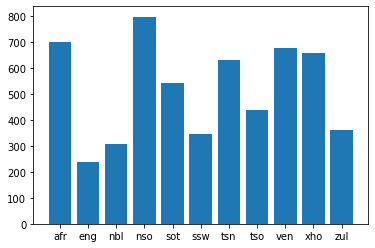

In [54]:
# Looking at the distribution of the predictions

unique, counts = np.unique(sub_list, return_counts=True)

plt.bar(unique,counts)
plt.show()

In [55]:
submission = pd.DataFrame(
    {'index': index,
     'lang_id': sub_list
    })

In [56]:
submission.to_csv("submission.csv", index=False)